# Imports, Setup, Dataset

In [119]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime
import random
import matplotlib.gridspec as gridspec
import matplotlib
from collections import Counter

In [120]:
cap_path = '/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/cap_data_from_shardar.csv'
price_path = "/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/Stocks_Data/price_data_from_shardar.csv"

# Reading Data:
prices_df = pd.read_csv(price_path, index_col='date')
caps_df = pd.read_csv(cap_path, index_col='date')

# Drop troubled stock...
prices_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)
caps_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)

prices_df.head()
caps_df.head()

,ATW,A,AA,AAAB,AABC,AAC1,AACC,AACE,AACH,AADI,...,ZVIA,ZVOI,ZVRA,ZVUE,ZVXI,ZY,ZYME,ZYNE,ZYXI,ZZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.265785,14.803789,NaN,0.002968,0.000000,0.055383,NaN,0.074688,NaN,NaN,...,NaN,NaN,NaN,NaN,0.010821,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.355094,13.938379,NaN,0.001050,0.000000,0.093997,NaN,0.036322,NaN,NaN,...,NaN,NaN,NaN,NaN,0.001050,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.597657,15.593232,NaN,0.002262,0.000000,0.082724,NaN,0.042248,NaN,NaN,...,NaN,NaN,NaN,NaN,0.002725,NaN,NaN,NaN,NaN,NaN
2000-01-06,0.377474,6.688876,NaN,0.003307,0.000000,0.071145,NaN,0.022496,NaN,NaN,...,NaN,NaN,NaN,NaN,0.006309,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.698268,8.061751,NaN,0.001843,0.000426,0.061952,NaN,0.005193,NaN,NaN,...,NaN,NaN,NaN,NaN,0.033459,NaN,NaN,NaN,NaN,NaN


In [121]:
prices_df.index = pd.to_datetime(prices_df.index)

# Get the initial start and end date
start_date = prices_df.index[0]
end_date = prices_df.index[-1]

# Download additional data:
spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)

# Set up dataframes:
prices_with_market = prices_df.merge(spy_data, how='left', left_index=True, right_index=True)

[*********************100%%**********************]  1 of 1 completed


In [122]:
# Pulling rougly the first half of data
num_rows = len(prices_df)
print(f'Original Length: {num_rows}')
train_df = prices_df[:np.round(num_rows/2).astype(int)]
num_rows = len(train_df)
print(f'Train Length: {num_rows}')

Original Length: 5787
Train Length: 2894


In [123]:
# Let's identify stocks with no null values
complete_stock_list = train_df.columns
non_null_stocks = []
for stock in complete_stock_list:
    # get the count of nulls
    null_count = train_df[stock].isnull().sum()
    if null_count == 0:
        non_null_stocks.append(stock)

print(len(complete_stock_list))
print(len(non_null_stocks))

10806
2467


# Sectors

In [154]:
# non_null_stocks is the list of usable stocks
query = "AAPL"

matches = [s for s in non_null_stocks if query in s]
print(matches)

['AAPL']


In [125]:
Market_dict = {
    'Technology': ['AAPL','MSFT','NVDA','ORCL','CSCO','IBM','ADBE','AMD','TXN','INTC'],
    'Financial Services' : ['AXP','BLK','PGR','','','','','','',''],
    'Consumer Cyclical': ['AMZN','HD','MCD','BKNG','LOW','TJX','SBUX','ORLY','',''],
    'Healthcare' : ['LLY','UNH','JNJ','MRK','ABT','AMGN','CVS','','',''],
    'Communication Services': ['TTWO','OMC','EA','','','','','','',''],
    'Industrials' : ['CAT','UNP','HON','BA','DE','ETN','UPS','WM','MMM','CTAS'],
    'Consumer Defensive' : ['WMT','COST','PG','KO','PEP','MO','CL','TGT','MNST','KR'],
    'Energy': ['XOM','COP','CVX','EPD','EOG','WMB','SLB','OKE','VLO','EQT'],
    'Basic Materials' : ['SHW','APD','SCCO','ECL','NEM','VMC','MLM','NUE','PPG','STLD'],
    'Real Estate' : ['PLD','AVB','CSGP','IRM','EQR','','','','',''],
    'Utilities': ['','','','','','','','','','']
}
# This is just some of the stocks that are available... maybe this could be better solved later

# Functions

### Clustering

In [126]:
def get_corr_matrix(DataFrame):
    return DataFrame.corr()

In [127]:
def K_mean_cluster(DataFrame, num_clusters):
    X = get_corr_matrix(DataFrame)
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)
    cluster_dict = {}
    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = DataFrame.columns[i]
        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]
    return cluster_dict

In [128]:
def spectral_cluster(df, num_clusters):
    A = abs(df.corr().values)
    D = np.diag(A.sum(axis=1))
    L = D - A
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)
    cluster_dict = {}
    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]
        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]
    return cluster_dict

### Trading

##### Version 1

In [129]:
def monthly_trading(DataFrame,Sector_Dict, months_to_run, cluster_method, num_clusters):
    #### Setup
    output_data = []
    index = DataFrame.index.tolist() # Get the list of timestamps
    first_day = index[0] # Start from the first timestamp
    trades_dict = {} # {Stock_Name: {Open_date: [], Close_date: [], Open_direction: [], Open_price: [], Close_price: []}}
    currently_in_trade = []

    #### Monthly Iteration
    for _ in range(months_to_run):
        #### Setup
        new_row = {}
        last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(0) 
        last_day_position = None
        current_last_day = last_day_of_month 
        new_row['timestamp'] = current_last_day
        while last_day_position is None: # Keep searching until we find a valid index position for the last day of the month
            try:
                last_day_position = next(
                    i for i, t in enumerate(index) if t.date() == current_last_day.date()
                )
            except StopIteration:
                current_last_day -= pd.Timedelta(days=1) # Backtrack by one day and try again if not found
                if current_last_day < first_day: # If backtracking goes too far, raise an error
                    raise ValueError(
                        f"Could not find a suitable last day for the month starting at {first_day}. "
                        "Backtracking exceeded the first day."
                    )
        next_day = current_last_day + pd.Timedelta(days=1) # Move to the next day after the last day of this month
        while next_day not in index: # Keep moving to the next day until a valid first day is found
            next_day += pd.Timedelta(days=1)

        #### Trading PT 1
        # check for stock/s in trade
            #check if there are any first
            if len(currently_in_trade) > 0:
                # iterate over the list
                for stock in currently_in_trade: 
                    # access the dictionary and close the stock
                    open_day = trades_dict[stock]['Open_date'][-1]
                    open_price = trades_dict[stock]['Open_price'][-1]
                    close_price = DataFrame.loc[current_last_day, stock]
                    trades_dict[stock]['Close_date'].append(current_last_day)
                    trades_dict[stock]['Close_price'].append(close_price)
                    if trades_dict[stock]['Trade_type'][-1] == 'Short':
                        profit = (open_price-close_price)/open_price
                    else: # 'Long'
                        profit = (close_price-open_price)/open_price
                    trades_dict[stock]['Profit'].append(profit)
                    currently_in_trade.remove(stock)

        #### Clustering
        if cluster_method == 'KMeans': # determine clustering method
            cluster_entry = K_mean_cluster(DataFrame[first_day:last_day_of_month], num_clusters)
        else:
            cluster_entry = spectral_cluster(DataFrame[first_day:last_day_of_month], num_clusters)
        for cluster in list(cluster_entry.keys()): # assign the the cluster members appropriately
            new_row[f'Cluster_{cluster}_Members'] = cluster_entry[cluster]

            #### Metrics calculation
            calcs = []
            clusters_stocks = cluster_entry[cluster]
            stock_to_sector = {stock: sector for sector, stocks in Sector_Dict.items() for stock in stocks}
            sector_count = Counter(stock_to_sector[stock] for stock in clusters_stocks if stock in stock_to_sector)
            majority_sector, majority_count = sector_count.most_common(1)[0]
            total_stocks = len(clusters_stocks)
            purity = (majority_count / total_stocks)
            calcs.append((f'Cluster_{cluster}_Purity',purity))   
            missclassification_rate = (1-(purity))
            calcs.append((f'Cluster_{cluster}_MR',missclassification_rate))
            if purity == 0 or purity == 1:
                entropy = 0  # log2(0) is undefined, and entropy should be 0 for pure sets
            else:
                entropy = -1 * ((purity * np.log2(purity)) + ((1 - purity) * np.log2(1 - purity)))
            calcs.append((f'Cluster_{cluster}_Entropy',entropy))
            for i in calcs: # assign the values appropriately
                key = i[0]
                val = i[1]
                new_row[key] = val
            missclassified_stocks = []
            correctly_classified_stocks = []
            if (purity > 0.5) and (purity != 1):
                missclassified_stocks = [stock for stock in clusters_stocks # record the missclassified stocks
                            if stock_to_sector.get(stock) != majority_sector] 
                correctly_classified_stocks = [stock for stock in clusters_stocks # record the correctly classified stocks
                            if stock_to_sector.get(stock) == majority_sector]
            new_row[f'Cluster_{cluster}_MisclassifiedStocks'] = missclassified_stocks

            ### Trading PT 2
            # open up new trades if possible
            if len(missclassified_stocks) == 1:
                # find the sector:
                trading_stock = missclassified_stocks[0] 
                for sector, stocks in Sector_Dict.items():
                    if trading_stock in stocks:
                        target_sector = sector
                # find its peers
                peer_stocks = []
                for stk in Sector_Dict[target_sector]:
                    if stk in DataFrame.columns:
                        peer_stocks.append(stk)
                peer_stocks.remove(trading_stock)
                # Check its peers' behavior
                up_cntr = 0
                down_cntr = 0
                for stk in peer_stocks:
                    price_data = DataFrame[stk][first_day:current_last_day]
                    covariance = np.cov(range(len(price_data)), price_data.values)
                    beta = covariance[0,1]
                    if beta > 0:
                        up_cntr +=1
                    else:
                        down_cntr +=1
                if up_cntr > down_cntr:
                    Trade_type = 'Long'
                else:
                    Trade_type = 'Short'
                # open the trade & record it
                # check if the stock exists in trades_dict, otherwise we have to create it
                current_price = DataFrame.loc[current_last_day, trading_stock]
                if trading_stock in list(trades_dict.keys()):
                    trades_dict[trading_stock]['Open_date'].append(current_last_day)
                    trades_dict[trading_stock]['Trade_type'].append(Trade_type)
                    trades_dict[trading_stock]['Open_price'].append(current_price)
                else: 
                    trades_dict[trading_stock] = {
                        'Open_date':[current_last_day],
                        'Close_date':[],
                        'Trade_type':[Trade_type],
                        'Open_price':[current_price],
                        'Close_price':[],
                        'Profit':[],
                    }
                currently_in_trade.append(trading_stock)

        #### Cleanup
        first_day = next_day # Set the first day for the next month
        output_data.append(new_row) # Append the month's row

    #### Output
    df = pd.DataFrame(output_data)
    df.set_index('timestamp', inplace=True)
    return df, trades_dict


##### Version 2

In [130]:
def trading_with_clustering(DataFrame,Sector_Dict, months_to_run, cluster_method, num_clusters):
    #### Setup
    output_data = []
    index = DataFrame.index.tolist() # Get the list of timestamps
    first_day = index[0] # Start from the first timestamp
    trades_dict = {} # {Stock_Name: {Open_date: [], Close_date: [], Open_direction: [], Open_price: [], Close_price: []}}
    currently_in_trade = []

    #### Monthly Iteration
    for _ in range(months_to_run):
        #### Setup
        new_row = {}
        last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(0) 
        last_day_position = None
        current_last_day = last_day_of_month 
        new_row['timestamp'] = current_last_day
        while last_day_position is None: # Keep searching until we find a valid index position for the last day of the month
            try:
                last_day_position = next(
                    i for i, t in enumerate(index) if t.date() == current_last_day.date()
                )
            except StopIteration:
                current_last_day -= pd.Timedelta(days=1) # Backtrack by one day and try again if not found
                if current_last_day < first_day: # If backtracking goes too far, raise an error
                    raise ValueError(
                        f"Could not find a suitable last day for the month starting at {first_day}. "
                        "Backtracking exceeded the first day."
                    )
        next_day = current_last_day + pd.Timedelta(days=1) # Move to the next day after the last day of this month
        while next_day not in index: # Keep moving to the next day until a valid first day is found
            next_day += pd.Timedelta(days=1)

        #### Trading PT 1
        # check for stock/s in trade
            #check if there are any first
            if len(currently_in_trade) > 0:
                # iterate over the list
                for stock in currently_in_trade: 
                    # access the dictionary and close the stock
                    open_day = trades_dict[stock]['Open_date'][-1]
                    open_price = trades_dict[stock]['Open_price'][-1]
                    close_price = DataFrame.loc[current_last_day, stock]
                    trades_dict[stock]['Close_date'].append(current_last_day)
                    trades_dict[stock]['Close_price'].append(close_price)
                    if trades_dict[stock]['Trade_type'][-1] == 'Short':
                        profit = (open_price-close_price)/open_price
                    else: # 'Long'
                        profit = (close_price-open_price)/open_price
                    trades_dict[stock]['Profit'].append(profit)
                    currently_in_trade.remove(stock)

        #### Clustering
        if cluster_method == 'KMeans': # determine clustering method
            cluster_entry = K_mean_cluster(DataFrame[first_day:last_day_of_month], num_clusters)
        else:
            cluster_entry = spectral_cluster(DataFrame[first_day:last_day_of_month], num_clusters)
        for cluster in list(cluster_entry.keys()): # assign the the cluster members appropriately
            new_row[f'Cluster_{cluster}_Members'] = cluster_entry[cluster]

            #### Metrics calculation
            calcs = []
            clusters_stocks = cluster_entry[cluster]
            stock_to_sector = {stock: sector for sector, stocks in Sector_Dict.items() for stock in stocks}
            sector_count = Counter(stock_to_sector[stock] for stock in clusters_stocks if stock in stock_to_sector)
            minority_sector, minority_count = sector_count.most_common()[-1]
            majority_sector, majority_count = sector_count.most_common(1)[0]
            total_stocks = len(clusters_stocks)
            purity = (majority_count / total_stocks)
            missclassified_stocks = []
            if (purity != (1/num_clusters)) and (purity != 1) :
                missclassified_stocks = [stock for stock in clusters_stocks # record the missclassified stocks
                                if stock_to_sector.get(stock) == minority_sector] 
            new_row[f'Cluster_{cluster}_MisclassifiedStocks'] = missclassified_stocks

            ### Trading PT 2
            # open up new trades if possible
            if len(missclassified_stocks) == 1:
                # find the sector:
                trading_stock = missclassified_stocks[0] 
                for sector, stocks in Sector_Dict.items():
                    if trading_stock in stocks:
                        target_sector = sector
                # find its peers
                peer_stocks = []
                for stk in Sector_Dict[target_sector]:
                    if stk in DataFrame.columns:
                        peer_stocks.append(stk)
                peer_stocks.remove(trading_stock)
                # Check its peers' behavior
                up_cntr = 0
                down_cntr = 0
                for stk in peer_stocks:
                    price_data = DataFrame[stk][first_day:current_last_day]
                    covariance = np.cov(range(len(price_data)), price_data.values)
                    beta = covariance[0,1]
                    if beta > 0:
                        up_cntr +=1
                    else:
                        down_cntr +=1
                if up_cntr > down_cntr:
                    Trade_type = 'Long'
                else:
                    Trade_type = 'Short'
                # open the trade & record it
                # check if the stock exists in trades_dict, otherwise we have to create it
                current_price = DataFrame.loc[current_last_day, trading_stock]
                if trading_stock in list(trades_dict.keys()):
                    trades_dict[trading_stock]['Open_date'].append(current_last_day)
                    trades_dict[trading_stock]['Trade_type'].append(Trade_type)
                    trades_dict[trading_stock]['Open_price'].append(current_price)
                else: 
                    trades_dict[trading_stock] = {
                        'Open_date':[current_last_day],
                        'Close_date':[],
                        'Trade_type':[Trade_type],
                        'Open_price':[current_price],
                        'Close_price':[],
                        'Profit':[],
                    }
                currently_in_trade.append(trading_stock)

        #### Cleanup
        first_day = next_day # Set the first day for the next month
        output_data.append(new_row) # Append the month's row

    #### Output
    df = pd.DataFrame(output_data)
    df.set_index('timestamp', inplace=True)
    return df, trades_dict

In [131]:
def trading_without_clustering(DataFrame,Sector_Dict, months_to_run):
    #### Setup
    index = DataFrame.index.tolist() # Get the list of timestamps
    first_day = index[0] # Start from the first timestamp
    trades_dict = {} # {Stock_Name: {Open_date: [], Close_date: [], Open_direction: [], Open_price: [], Close_price: []}}
    currently_in_trade = []

    #### Monthly Iteration
    for _ in range(months_to_run):
        #### Setup
        new_row = {}
        last_day_of_month = pd.Timestamp(first_day.year, first_day.month, 1) + pd.offsets.MonthEnd(0) 
        last_day_position = None
        current_last_day = last_day_of_month 
        new_row['timestamp'] = current_last_day
        while last_day_position is None: # Keep searching until we find a valid index position for the last day of the month
            try:
                last_day_position = next(
                    i for i, t in enumerate(index) if t.date() == current_last_day.date()
                )
            except StopIteration:
                current_last_day -= pd.Timedelta(days=1) # Backtrack by one day and try again if not found
                if current_last_day < first_day: # If backtracking goes too far, raise an error
                    raise ValueError(
                        f"Could not find a suitable last day for the month starting at {first_day}. "
                        "Backtracking exceeded the first day."
                    )
        next_day = current_last_day + pd.Timedelta(days=1) # Move to the next day after the last day of this month
        while next_day not in index: # Keep moving to the next day until a valid first day is found
            next_day += pd.Timedelta(days=1)

        #### Trading PT 1
        # check for stock/s in trade
        if len(currently_in_trade) > 0:
            # iterate over the list
            for stock in currently_in_trade: 
            # access the dictionary and close the stock
                open_day = trades_dict[stock]['Open_date'][-1]
                open_price = trades_dict[stock]['Open_price'][-1]
                close_price = DataFrame.loc[current_last_day, stock]
                trades_dict[stock]['Close_date'].append(current_last_day)
                trades_dict[stock]['Close_price'].append(close_price)
                if trades_dict[stock]['Trade_type'][-1] == 'Short':
                    profit = (open_price-close_price)/open_price
                else: # 'Long'
                    profit = (close_price-open_price)/open_price
                trades_dict[stock]['Profit'].append(profit)
                currently_in_trade.remove(stock)
                    
        ### iterate over each sector
        Current_Sectors = {}
        for stk in DataFrame.columns:
            for sector in list(Sector_Dict.keys()):
                if stk in Sector_Dict[sector]:
                    if sector not in list(Current_Sectors.keys()):
                        Current_Sectors[sector] = [stk]
                    else:
                        Current_Sectors[sector].append(stk)
        for sector in list(Current_Sectors.keys()):
            ### look at the sign count
            up_stocks = []
            down_stocks = []
            for stk in Current_Sectors[sector]:
                price_data = DataFrame[stk][first_day:current_last_day]
                covariance = np.cov(range(len(price_data)), price_data.values)
                beta = covariance[0,1]
                if beta > 0:
                    up_stocks.append(stk)
                else:
                    down_stocks.append(stk)
            # if a minority n number of stocks is not following the group, we trade
            if len(up_stocks) != len(down_stocks): # adjust this in the future to be more specific?...
                if len(up_stocks) > len(down_stocks):
                    Trade_type = 'Long'
                    minority_stocks = down_stocks
                else:
                    Trade_type = 'Short'
                    minority_stocks = up_stocks
                # find the minority stock/s
                for trading_stock in minority_stocks:
                    # check if the stock exists in trades_dict, otherwise we have to create it
                    current_price = DataFrame.loc[current_last_day, trading_stock]
                    if trading_stock in list(trades_dict.keys()):
                        trades_dict[trading_stock]['Open_date'].append(current_last_day)
                        trades_dict[trading_stock]['Trade_type'].append(Trade_type)
                        trades_dict[trading_stock]['Open_price'].append(current_price)
                    else: 
                        trades_dict[trading_stock] = {
                            'Open_date':[current_last_day],
                            'Close_date':[],
                            'Trade_type':[Trade_type],
                            'Open_price':[current_price],
                            'Close_price':[],
                            'Profit':[],
                        }
                    currently_in_trade.append(trading_stock)

        # move days
        first_day = next_day   

    ### output trading dict
    return trades_dict

### Analysis

In [132]:
def calc_avg_profit(trading_dict):
    all_profits = []
    for stock in list(trading_dict.keys()):
        profits = trading_dict[stock]['Profit']
        for profit in profits:
            all_profits.append(profit)
    return (sum(all_profits)/len(all_profits))

In [133]:
def calc_cum_sum(trading_dict):
    all_profits = []
    for stock in list(trading_dict.keys()):
        profits = trading_dict[stock]['Profit']
        for profit in profits:
            all_profits.append(profit)
    all_profits = np.array(all_profits)
    return np.cumsum(all_profits)

In [134]:
def calc_trading_profit_df(trading_dict):
    # Collect all timestamps and sort them
    all_timestamps = sorted(set(ts for stock in trading_dict for ts in trading_dict[stock]['Close_date']))
    
    stock_profits = {'Time': all_timestamps}
    
    for stock, data in trading_dict.items():
        stock_profits[stock] = []
        trade_times = data['Close_date']
        profits = data['Profit']
        
        cumulative_profit = 0
        trade_index = 0
        
        for timestamp in all_timestamps:
            if trade_index < len(trade_times) and trade_times[trade_index] == timestamp:
                cumulative_profit += profits[trade_index]
                trade_index += 1
            
            stock_profits[stock].append(cumulative_profit)
    
    return pd.DataFrame(stock_profits).set_index('Time')


In [135]:
def analyze_trading_results(trading_results):
    for stock, results in trading_results.items():
        num_long = sum(1 for trade in results['Trade_type'] if trade == "Long")
        num_short = len(results['Trade_type']) - num_long
        
        long_profit = [profit for trade, profit in zip(results['Trade_type'], results['Profit']) if trade == "Long"]
        short_profit = [profit for trade, profit in zip(results['Trade_type'], results['Profit']) if trade == "Short"]
        overall_profit = results['Profit']
        
        def calculate_positive_proportion(profits):
            return sum(1 for p in profits if p > 0) / len(profits) if profits else None
        
        overall_proportion_pos = calculate_positive_proportion(overall_profit)
        long_proportion_pos = calculate_positive_proportion(long_profit)
        short_proportion_pos = calculate_positive_proportion(short_profit)
        
        print(stock)
        print(f'Num Long: {num_long}', f'{long_proportion_pos:.2%} positive profit' if long_proportion_pos is not None else '')
        print(f'Num Short: {num_short}', f'{short_proportion_pos:.2%} positive profit' if short_proportion_pos is not None else '')


In [136]:
def cum_sum_plot(trading_results):
    # Get all the possible timestamps
    all_timestamps = sorted(set(ts for stock in trading_results for ts in trading_results[stock]['Close_date']))
    
    temp_data = {
        'Time': all_timestamps,
        'Cumulative_Sum': []
    }
    
    cum_sum = 0
    for timestamp in all_timestamps:
        # Find profits for this timestamp
        profits = []
        for stock in trading_results:
            for index_pos, ts in enumerate(trading_results[stock]['Close_date']):
                if ts == timestamp:
                    profits.append(trading_results[stock]['Profit'][index_pos])

        # Ensure cumulative sum is increasing correctly
        cum_sum += np.sum(profits)
        temp_data['Cumulative_Sum'].append(cum_sum)
    
    return pd.DataFrame(temp_data).set_index('Time')


# Testing

### 2 Sectors

In [137]:
stocks_to_run = ['AAPL', 'MSFT', 'NVDA', 'ORCL','XOM', 'COP', 'CVX', 'EPD']
                # Tech                          # Energy                    
results_df, clustering_trading_results = trading_with_clustering(train_df[stocks_to_run],Market_dict, 115, "KMeans", 2)
trading_results_without_clustering = trading_without_clustering(train_df[stocks_to_run], Market_dict, 115)

In [138]:
results_df

,Cluster_1_Members,Cluster_1_MisclassifiedStocks,Cluster_0_Members,Cluster_0_MisclassifiedStocks
timestamp,,,,
2000-01-31,"[AAPL, EPD]",[],"[MSFT, NVDA, ORCL, XOM, COP, CVX]",[]
2000-02-29,"[MSFT, XOM, COP, CVX, EPD]",[MSFT],"[AAPL, NVDA, ORCL]",[]
2000-03-31,"[NVDA, XOM, EPD]",[NVDA],"[AAPL, MSFT, ORCL, COP, CVX]","[COP, CVX]"
2000-04-30,"[COP, EPD]",[],"[AAPL, MSFT, NVDA, ORCL, XOM, CVX]","[XOM, CVX]"
2000-05-31,"[NVDA, XOM, COP, CVX, EPD]",[NVDA],"[AAPL, MSFT, ORCL]",[]
...,...,...,...,...
2009-03-31,"[NVDA, XOM, COP]",[NVDA],"[AAPL, MSFT, ORCL, CVX, EPD]","[CVX, EPD]"
2009-04-30,"[XOM, COP, CVX]",[],"[AAPL, MSFT, NVDA, ORCL, EPD]",[EPD]
2009-05-31,"[XOM, COP, CVX]",[],"[AAPL, MSFT, NVDA, ORCL, EPD]",[EPD]


In [139]:
print(f'with    Clustering Avg.Profit: {calc_avg_profit(clustering_trading_results)}')
print(f'without Clustering Avg.Profit: {calc_avg_profit(trading_results_without_clustering)}')

with    Clustering Avg.Profit: 0.027186625933790513
without Clustering Avg.Profit: -0.01620089702372472


<Axes: xlabel='Time'>

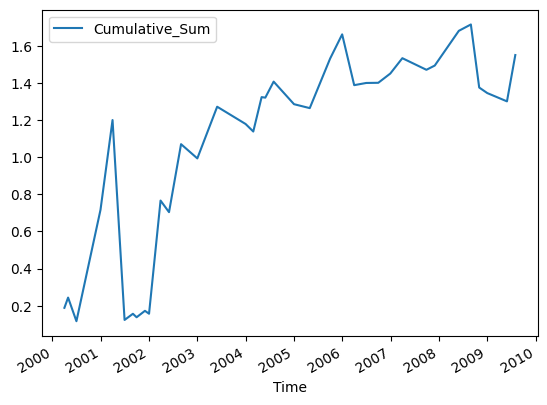

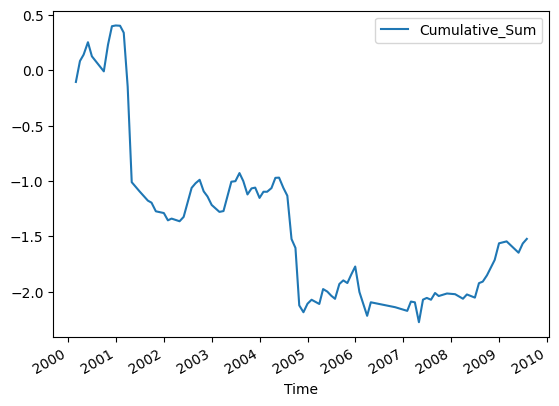

In [140]:
cum_sum_plot(clustering_trading_results).plot()
cum_sum_plot(trading_results_without_clustering).plot()

In [141]:
print('----------   With Clustering  ----------')
analyze_trading_results(clustering_trading_results)
print('---------- Without Clustering ----------')
analyze_trading_results(trading_results_without_clustering)

----------   With Clustering  ----------
MSFT
Num Long: 3 66.67% positive profit
Num Short: 3 66.67% positive profit
NVDA
Num Long: 6 83.33% positive profit
Num Short: 7 28.57% positive profit
XOM
Num Long: 4 0.00% positive profit
Num Short: 1 100.00% positive profit
ORCL
Num Long: 3 33.33% positive profit
Num Short: 2 100.00% positive profit
EPD
Num Long: 12 50.00% positive profit
Num Short: 12 83.33% positive profit
AAPL
Num Long: 3 66.67% positive profit
Num Short: 0 
CVX
Num Long: 1 0.00% positive profit
Num Short: 0 
---------- Without Clustering ----------
AAPL
Num Long: 5 75.00% positive profit
Num Short: 7 28.57% positive profit
MSFT
Num Long: 5 40.00% positive profit
Num Short: 6 66.67% positive profit
EPD
Num Long: 14 50.00% positive profit
Num Short: 20 55.00% positive profit
NVDA
Num Long: 8 62.50% positive profit
Num Short: 7 14.29% positive profit
COP
Num Long: 2 100.00% positive profit
Num Short: 2 100.00% positive profit
ORCL
Num Long: 5 40.00% positive profit
Num Short

### 3 Sectors

In [142]:
stocks_to_run = ['AAPL', 'MSFT', 'NVDA', 'ORCL','XOM', 'COP', 'CVX', 'EPD','LLY','UNH','JNJ','MRK']
                # Tech                          # Energy                    # Healthcare
results_df, clustering_trading_results = trading_with_clustering(train_df[stocks_to_run],Market_dict, 115, "KMeans", 3)
trading_results_without_clustering = trading_without_clustering(train_df[stocks_to_run], Market_dict, 115)

In [143]:
results_df

,Cluster_0_Members,Cluster_0_MisclassifiedStocks,Cluster_2_Members,Cluster_2_MisclassifiedStocks,Cluster_1_Members,Cluster_1_MisclassifiedStocks
timestamp,,,,,,
2000-01-31,"[AAPL, EPD, MRK]",[],"[MSFT, NVDA, ORCL, COP]",[COP],"[XOM, CVX, LLY, UNH, JNJ]","[XOM, CVX]"
2000-02-29,"[MSFT, XOM, COP, CVX, LLY, JNJ, MRK]",[MSFT],"[EPD, UNH]",[UNH],"[AAPL, NVDA, ORCL]",[]
2000-03-31,[JNJ],[],"[NVDA, XOM, EPD]",[NVDA],"[AAPL, MSFT, ORCL, COP, CVX, LLY, UNH, MRK]","[COP, CVX]"
2000-04-30,"[AAPL, NVDA, ORCL]",[],"[MSFT, XOM, CVX]",[MSFT],"[COP, EPD, LLY, UNH, JNJ, MRK]","[COP, EPD]"
2000-05-31,"[NVDA, XOM, COP, CVX, EPD, UNH, JNJ, MRK]",[NVDA],[LLY],[],"[AAPL, MSFT, ORCL]",[]
...,...,...,...,...,...,...
2009-03-31,"[MSFT, ORCL, COP]",[COP],"[NVDA, XOM, UNH]",[],"[AAPL, CVX, EPD, LLY, JNJ, MRK]",[AAPL]
2009-04-30,"[COP, LLY]",[LLY],"[XOM, CVX, JNJ, MRK]","[JNJ, MRK]","[AAPL, MSFT, NVDA, ORCL, EPD, UNH]",[UNH]
2009-05-31,"[AAPL, NVDA, ORCL]",[],"[MSFT, EPD, MRK]",[],"[XOM, COP, CVX, LLY, UNH, JNJ]","[LLY, UNH, JNJ]"


In [144]:
print(f'with    Clustering Avg.Profit: {calc_avg_profit(clustering_trading_results)}')
print(f'without Clustering Avg.Profit: {calc_avg_profit(trading_results_without_clustering)}')

with    Clustering Avg.Profit: -0.016785017881848347
without Clustering Avg.Profit: 0.009743604249365403


<Axes: xlabel='Time'>

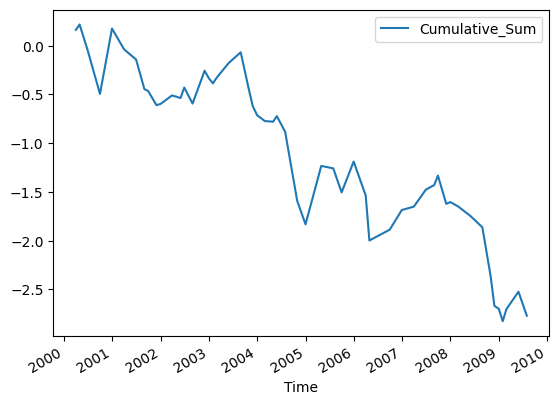

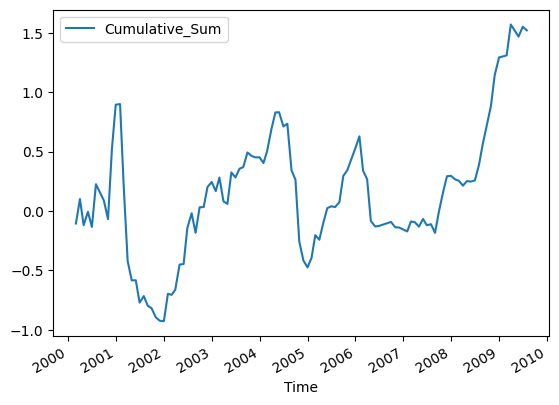

In [145]:
cum_sum_plot(clustering_trading_results).plot()
cum_sum_plot(trading_results_without_clustering).plot()

In [146]:
print('----------   With Clustering  ----------')
analyze_trading_results(clustering_trading_results)
print('---------- Without Clustering ----------')
analyze_trading_results(trading_results_without_clustering)

----------   With Clustering  ----------
COP
Num Long: 4 50.00% positive profit
Num Short: 1 0.00% positive profit
MSFT
Num Long: 10 40.00% positive profit
Num Short: 6 33.33% positive profit
UNH
Num Long: 11 45.45% positive profit
Num Short: 23 30.43% positive profit
NVDA
Num Long: 5 60.00% positive profit
Num Short: 9 22.22% positive profit
EPD
Num Long: 12 8.33% positive profit
Num Short: 13 7.69% positive profit
XOM
Num Long: 2 50.00% positive profit
Num Short: 3 33.33% positive profit
JNJ
Num Long: 6 20.00% positive profit
Num Short: 10 30.00% positive profit
LLY
Num Long: 8 50.00% positive profit
Num Short: 7 14.29% positive profit
MRK
Num Long: 10 70.00% positive profit
Num Short: 6 33.33% positive profit
AAPL
Num Long: 5 60.00% positive profit
Num Short: 4 50.00% positive profit
ORCL
Num Long: 6 33.33% positive profit
Num Short: 2 100.00% positive profit
CVX
Num Long: 3 33.33% positive profit
Num Short: 0 
---------- Without Clustering ----------
AAPL
Num Long: 5 50.00% positiv

### 4 Sectors

In [147]:
stocks_to_run = ['AAPL', 'MSFT', 'NVDA', 'ORCL','XOM', 'COP', 'CVX', 'EPD','LLY','UNH','JNJ','MRK','AMZN','HD','MCD','BKNG']
                # Tech                          # Energy                    # Healthcare            # Consumer Cyclical
results_df, clustering_trading_results = trading_with_clustering(train_df[stocks_to_run],Market_dict, 115, "KMeans", 4)
trading_results_without_clustering = trading_without_clustering(train_df[stocks_to_run], Market_dict, 115)

In [148]:
results_df

,Cluster_2_Members,Cluster_2_MisclassifiedStocks,Cluster_0_Members,Cluster_0_MisclassifiedStocks,Cluster_1_Members,Cluster_1_MisclassifiedStocks,Cluster_3_Members,Cluster_3_MisclassifiedStocks
timestamp,,,,,,,,
2000-01-31,"[AAPL, EPD, BKNG]",[BKNG],"[MSFT, COP, LLY, UNH, JNJ, HD, MCD]",[COP],"[NVDA, ORCL, AMZN]",[AMZN],"[XOM, CVX, MRK]",[MRK]
2000-02-29,"[EPD, UNH]",[UNH],"[XOM, COP, CVX, LLY, JNJ, MRK, MCD]",[MCD],"[AAPL, NVDA, ORCL]",[],"[MSFT, AMZN, HD, BKNG]",[MSFT]
2000-03-31,[JNJ],[],"[AAPL, MSFT, ORCL, COP, CVX, LLY, UNH, MRK, AM...","[COP, CVX]",[XOM],[],"[NVDA, EPD, BKNG]",[BKNG]
2000-04-30,"[MSFT, CVX, AMZN, HD]",[CVX],"[XOM, MCD]",[MCD],"[COP, EPD, LLY, UNH, JNJ, MRK]","[COP, EPD]","[AAPL, NVDA, ORCL, BKNG]",[BKNG]
2000-05-31,[MCD],[],"[NVDA, XOM, COP, CVX, EPD, UNH, JNJ, MRK]",[NVDA],"[AAPL, MSFT, ORCL, AMZN, HD, BKNG]","[AMZN, HD, BKNG]",[LLY],[]
...,...,...,...,...,...,...,...,...
2009-03-31,"[AAPL, MSFT, ORCL, XOM, COP, CVX, EPD, LLY, JN...","[AMZN, HD]","[NVDA, UNH]",[UNH],[BKNG],[],[MCD],[]
2009-04-30,"[COP, LLY]",[LLY],"[XOM, CVX, JNJ, MRK, MCD]",[MCD],"[AAPL, MSFT, ORCL, EPD, AMZN, HD, BKNG]",[EPD],"[NVDA, UNH]",[UNH]
2009-05-31,"[XOM, COP, LLY, UNH, JNJ]","[XOM, COP]","[CVX, HD]",[HD],"[AAPL, NVDA, ORCL, AMZN]",[AMZN],"[MSFT, EPD, MRK, MCD, BKNG]",[MRK]


In [149]:
print(f'with    Clustering Avg.Profit: {calc_avg_profit(clustering_trading_results)}')
print(f'without Clustering Avg.Profit: {calc_avg_profit(trading_results_without_clustering)}')

with    Clustering Avg.Profit: 0.0013738863382838206
without Clustering Avg.Profit: 0.011582968585308152


<Axes: xlabel='Time'>

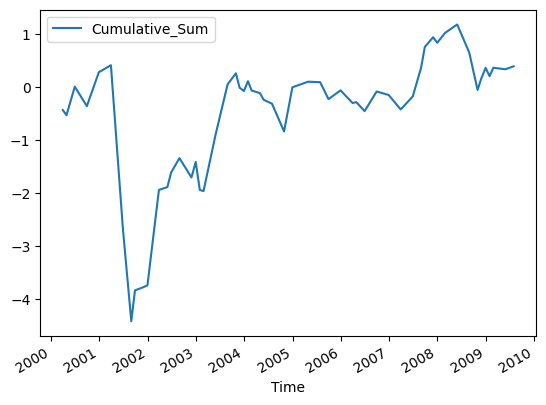

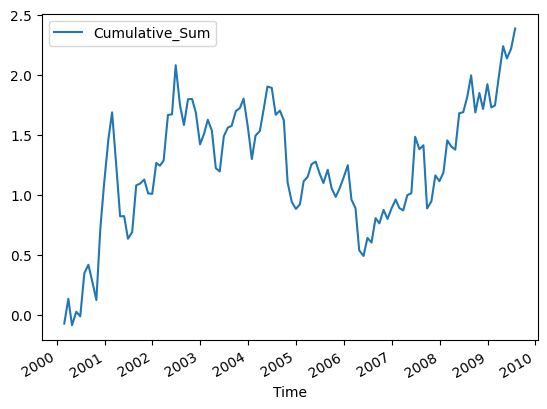

In [150]:
cum_sum_plot(clustering_trading_results).plot()
cum_sum_plot(trading_results_without_clustering).plot()

In [151]:
print('----------   With Clustering  ----------')
analyze_trading_results(clustering_trading_results)
print('---------- Without Clustering ----------')
analyze_trading_results(trading_results_without_clustering)

----------   With Clustering  ----------
BKNG
Num Long: 17 58.82% positive profit
Num Short: 14 50.00% positive profit
COP
Num Long: 5 60.00% positive profit
Num Short: 6 33.33% positive profit
AMZN
Num Long: 19 61.11% positive profit
Num Short: 14 42.86% positive profit
MRK
Num Long: 9 75.00% positive profit
Num Short: 6 50.00% positive profit
MSFT
Num Long: 9 55.56% positive profit
Num Short: 1 100.00% positive profit
MCD
Num Long: 22 63.64% positive profit
Num Short: 22 54.55% positive profit
UNH
Num Long: 11 36.36% positive profit
Num Short: 24 29.17% positive profit
CVX
Num Long: 2 50.00% positive profit
Num Short: 1 0.00% positive profit
NVDA
Num Long: 7 42.86% positive profit
Num Short: 6 50.00% positive profit
HD
Num Long: 20 50.00% positive profit
Num Short: 11 54.55% positive profit
ORCL
Num Long: 3 66.67% positive profit
Num Short: 2 100.00% positive profit
JNJ
Num Long: 7 33.33% positive profit
Num Short: 6 16.67% positive profit
EPD
Num Long: 8 37.50% positive profit
Num S

### 5 Sectors

In [152]:
stocks_to_run = ['AAPL', 'MSFT', 'NVDA', 'ORCL','XOM', 'COP', 'CVX', 'EPD','LLY','UNH','JNJ','MRK','AMZN','HD','MCD','BKNG','WMT','COST','PG','KO']
                # Tech                          # Energy                    # Healthcare            # Consumer Cyclical     # Consumer Defense
trading_results_without_clustering = trading_without_clustering(train_df[stocks_to_run], Market_dict, 115)

<Axes: xlabel='Time'>

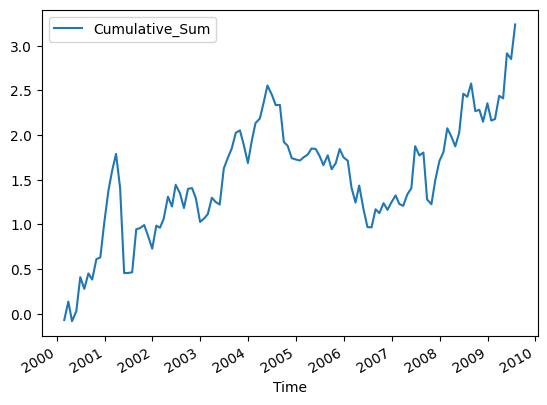

In [153]:
cum_sum_plot(trading_results_without_clustering).plot()

### 6 Sectors
